<a href="https://colab.research.google.com/github/abdulhasibuddin/My-Deep-Neural-Network/blob/master/Time_series_1_4_Unistep_Univariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.compat.v2.keras.models import Sequential
from tensorflow.compat.v2.keras.layers import TimeDistributed, Bidirectional, LSTM, Dense, GRU, Conv2D, Conv3D, Conv1D, ConvLSTM2D
import statistics as stat
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
from IPython.display import clear_output

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


In [0]:
# HYPER-PARAMETERS::
DATASET_TYPE = 'sin' #'sin'
DATASET_START_INDEX = 0
DATASET_END_INDEX = 400 #1000000
DATA_INTERVAL = 1
VALIDATION_DATASET_SIZE = 20
TESTING_DATASET_START_INDEX = 421
TESTING_DATASET_END_INDEX = 430

#TRAIN_SPLIT_RATIO = 0.8
UNIVARIATE_PAST_HISTORY = 5
UNIVARIATE_FUTURE_TARGET = 0

#BUFFER_SIZE = 2
BATCH_SIZE_TRAIN = 1
#BATCH_SIZE_VAL = 5
#BATCH_SIZE = 5
EPOCHS = 5
NUM_LAYERS = 5
NEURONS_PER_LAYER = 6

In [0]:
def create_dataset(dataset_type, start_index, end_index, interval):
  dataset = []
  for degree in range(start_index, end_index, interval):
    if dataset_type == 'sin':
      dataset.append(np.sin(np.deg2rad(degree)))
    elif dataset_type == 'cos':
      dataset.append(np.cos(np.deg2rad(degree)))
    elif dataset_type == 'tan':
      dataset.append(np.tan(np.deg2rad(degree)))
    elif dataset_type == 'cot':
      dataset.append(1/(np.tan(np.deg2rad(degree))))
    elif dataset_type == 'sec':
      dataset.append(1/(np.cos(np.deg2rad(degree))))
    elif dataset_type == 'cosec':
      dataset.append(1/(np.sin(np.deg2rad(degree))))
    elif dataset_type == 'num':
      dataset.append(float(degree))
  return pd.DataFrame(dataset, columns=['values'])

In [4]:
df_training_dataset = create_dataset(DATASET_TYPE, DATASET_START_INDEX, DATASET_END_INDEX, DATA_INTERVAL)
df_training_dataset.shape

(400, 1)

In [5]:
df_validation_dataset = create_dataset(DATASET_TYPE, DATASET_END_INDEX, DATASET_END_INDEX+VALIDATION_DATASET_SIZE, DATA_INTERVAL)
df_validation_dataset.shape

(20, 1)

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  print('dataset.shape =',dataset.shape)
  print('start_index =',start_index)
  print('end_index =',end_index)
  print('history_size =',history_size)
  print('target_size =',target_size)

  for i in range(start_index, end_index):
    #try:
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1):
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    #except:
     # pass
  print('no. of data =',len(data))
  print('no. of labels =',len(labels))
  return np.array(data), np.array(labels)

In [0]:
# Setting seed to ensure reproducibility
tf.random.set_seed(13)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5a1cabcc0>],
      dtype=object)

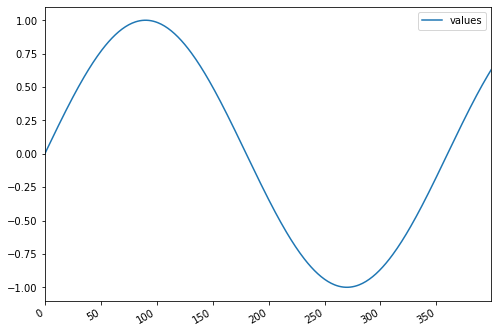

In [8]:
df_training_dataset.plot(subplots=True)

In [9]:
training_dataset = df_training_dataset['values']
training_dataset.index = df_training_dataset.index
validation_dataset = df_validation_dataset['values']
validation_dataset.index = df_validation_dataset.index

print('type(training_dataset) =',type(training_dataset))
print('type(validation_dataset) =',type(validation_dataset))
print('training_dataset.shape =',training_dataset.shape)
print('validation_dataset.shape =',validation_dataset.shape)
#training_dataset.head()

type(training_dataset) = <class 'pandas.core.series.Series'>
type(validation_dataset) = <class 'pandas.core.series.Series'>
training_dataset.shape = (400,)
validation_dataset.shape = (20,)


In [10]:
training_dataset_values = training_dataset.values
num_training_data = training_dataset_values.shape[0]
validation_dataset_values = validation_dataset.values
num_validation_data = validation_dataset_values.shape[0]

print('no. of training data =',num_training_data)
print('no. of validation data =',num_validation_data)
print('type(training_dataset_values) =',type(training_dataset_values))
print('type(validation_dataset_values) =',type(validation_dataset_values))
print('training_dataset_values.shape =',training_dataset_values.shape)
print('validation_dataset_values.shape =',validation_dataset_values.shape)

no. of training data = 400
no. of validation data = 20
type(training_dataset_values) = <class 'numpy.ndarray'>
type(validation_dataset_values) = <class 'numpy.ndarray'>
training_dataset_values.shape = (400,)
validation_dataset_values.shape = (20,)


In [11]:
mean_training_dataset = training_dataset_values.mean()
std_training_dataset = training_dataset_values.std()

print('mean_training_dataset =',mean_training_dataset)
print('std_training_dataset =',std_training_dataset)

mean_training_dataset = 0.03270732980445086
std_training_dataset = 0.68055235779348


In [0]:
# Normalization:
def normalize(dataset):
    normalized_dataset = (dataset-mean_training_dataset)/std_training_dataset
    return normalized_dataset

In [0]:
# Denormalization:
def denormalize(normalized_data):
  denormalized_data = normalized_data*std_training_dataset + mean_training_dataset
  return denormalized_data

In [14]:
# Normalization:
training_dataset_normalized = normalize(training_dataset_values)
validation_dataset_normalized = normalize(validation_dataset_values) # normalization have to be same

print('training_dataset_normalized.shape =',training_dataset_normalized.shape)
print('validation_dataset_normalized.shape =',validation_dataset_normalized.shape)
print('type(training_dataset_normalized) =',type(training_dataset_normalized))
print('type(validation_dataset_normalized) =',type(validation_dataset_normalized))

training_dataset_normalized.shape = (400,)
validation_dataset_normalized.shape = (20,)
type(training_dataset_normalized) = <class 'numpy.ndarray'>
type(validation_dataset_normalized) = <class 'numpy.ndarray'>


In [15]:
univariate_past_history = UNIVARIATE_PAST_HISTORY
univariate_future_target = UNIVARIATE_FUTURE_TARGET

print('Training:')
x_train_uni, y_train_uni = univariate_data(training_dataset_normalized, 0, None,
                                           univariate_past_history,
                                           univariate_future_target)
print('\nValidation:')
x_val_uni, y_val_uni = univariate_data(validation_dataset_normalized, 0, None,
                                       univariate_past_history,
                                       univariate_future_target)

Training:
dataset.shape = (400,)
start_index = 5
end_index = 400
history_size = 5
target_size = 0
no. of data = 395
no. of labels = 395

Validation:
dataset.shape = (20,)
start_index = 5
end_index = 20
history_size = 5
target_size = 0
no. of data = 15
no. of labels = 15


In [16]:
print('x_train_uni.shape =',x_train_uni.shape)
print('y_train_uni.shape =',y_train_uni.shape)
print('x_val_uni.shape =',x_val_uni.shape)
print('y_val_uni.shape =',y_val_uni.shape)
print('num_val_data =',y_val_uni.shape[0])
print('type(x_train_uni) =',type(x_train_uni))
print('type(y_train_uni) =',type(y_train_uni))
print('type(x_val_uni) =',type(x_val_uni))
print('type(y_val_uni) =',type(y_val_uni))

print('\nLast value of the window of past history =',x_train_uni[0][-1])
print('Target value to predict =',y_train_uni[0])

x_train_uni.shape = (395, 5, 1)
y_train_uni.shape = (395,)
x_val_uni.shape = (15, 5, 1)
y_val_uni.shape = (15,)
num_val_data = 15
type(x_train_uni) = <class 'numpy.ndarray'>
type(y_train_uni) = <class 'numpy.ndarray'>
type(x_val_uni) = <class 'numpy.ndarray'>
type(y_val_uni) = <class 'numpy.ndarray'>

Last value of the window of past history = [0.05443981]
Target value to predict = 0.08000620719284936


In [0]:
def create_time_steps(length): # only needed for plots
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i],
               label=labels[i])
      
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])

  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

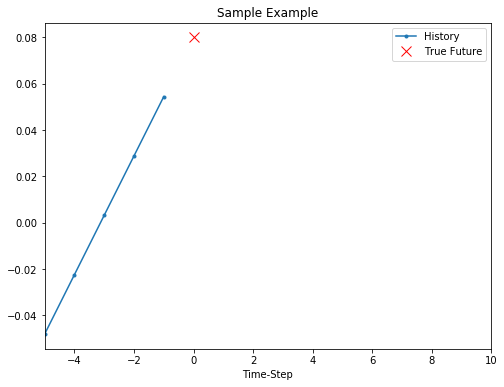

In [19]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [20]:
print('(# of training data, features, time steps) =',x_train_uni.shape)
print('x_train_uni.shape[-2:] =',x_train_uni.shape[-2:])
print('y_train_uni.shape =',y_train_uni.shape)
print('y_train_uni.shape[0] =',y_train_uni.shape[0])

print('\n(# of validation data, features, time steps) =',x_val_uni.shape)
print('x_val_uni.shape[-2:] =',x_val_uni.shape[-2:])
print('y_val_uni.shape =',y_val_uni.shape)
print('y_val_uni.shape[0] =',y_val_uni.shape[0])

(# of training data, features, time steps) = (395, 5, 1)
x_train_uni.shape[-2:] = (5, 1)
y_train_uni.shape = (395,)
y_train_uni.shape[0] = 395

(# of validation data, features, time steps) = (15, 5, 1)
x_val_uni.shape[-2:] = (5, 1)
y_val_uni.shape = (15,)
y_val_uni.shape[0] = 15


In [21]:
x_train_uni[0][0][0]

-0.048059975738672274

MODEL

In [140]:
myModel = Sequential()
myModel.add(GRU(NEURONS_PER_LAYER, input_shape=x_train_uni.shape[-2:], return_sequences=True))
for _ in range(NUM_LAYERS-2):
    myModel.add(Bidirectional(GRU(NEURONS_PER_LAYER, return_sequences=True)))
myModel.add(Bidirectional(GRU(NEURONS_PER_LAYER))) # at last RNN layer, 'return_sequences=True' will create problem in prediction shape.
myModel.add(Dense(1))
myModel.compile(optimizer='adam', loss='mae')
#myModel.build(x_train_uni.shape[-2:])
myModel.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_42 (GRU)                 (None, 5, 6)              162       
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 5, 12)             504       
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 5, 12)             720       
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 5, 12)             720       
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 12)                720       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 13        
Total params: 2,839
Trainable params: 2,839
Non-trainable params: 0
____________________________________________________

TRAINING

In [141]:
history = myModel.fit(x_train_uni, y_train_uni,
                    batch_size=BATCH_SIZE_TRAIN,
                    epochs=EPOCHS,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(x_val_uni, y_val_uni)
                    )

Train on 395 samples, validate on 15 samples
Epoch 1/5
395/395 [==============================] - 21s 54ms/sample - loss: 0.1665 - val_loss: 0.0306
Epoch 2/5
395/395 [==============================] - 7s 18ms/sample - loss: 0.0939 - val_loss: 0.0927
Epoch 3/5
395/395 [==============================] - 7s 18ms/sample - loss: 0.0791 - val_loss: 0.0335
Epoch 4/5
395/395 [==============================] - 7s 18ms/sample - loss: 0.0702 - val_loss: 0.0823
Epoch 5/5
395/395 [==============================] - 7s 18ms/sample - loss: 0.0645 - val_loss: 0.0057


In [142]:
print('loss =',history.history['loss'])
print('val_loss =',history.history['val_loss'])

loss = [0.16649567586711692, 0.09394935683547696, 0.07908418792523915, 0.07017757458777367, 0.06449337674752821]
val_loss = [0.03056055704752604, 0.09267734289169312, 0.03345146179199219, 0.08233654499053955, 0.005672367413838705]


PREDICTION

In [143]:
df_test_dataset = create_dataset(DATASET_TYPE, TESTING_DATASET_START_INDEX, TESTING_DATASET_END_INDEX, DATA_INTERVAL)
print(type(df_test_dataset))
print('df_test_dataset.shape =',df_test_dataset.shape)

test_dataset = df_test_dataset['values'].values
print('type(test_dataset) =',type(test_dataset))
print('\ntest_dataset.shape =',test_dataset.shape)

test_dataset_normalized = normalize(test_dataset)

print('\nTest dataset without normalization:')
x_test_uni, y_test_uni = univariate_data(test_dataset, 0, None,
                                           UNIVARIATE_PAST_HISTORY,
                                           UNIVARIATE_FUTURE_TARGET)

print('\nTest dataset with normalization:')
x_test_uni_normalized, y_test_uni_normalized = univariate_data(test_dataset_normalized, 0, None,
                                           UNIVARIATE_PAST_HISTORY,
                                           UNIVARIATE_FUTURE_TARGET)

<class 'pandas.core.frame.DataFrame'>
df_test_dataset.shape = (9, 1)
type(test_dataset) = <class 'numpy.ndarray'>

test_dataset.shape = (9,)

Test dataset without normalization:
dataset.shape = (9,)
start_index = 5
end_index = 9
history_size = 5
target_size = 0
no. of data = 4
no. of labels = 4

Test dataset with normalization:
dataset.shape = (9,)
start_index = 5
end_index = 9
history_size = 5
target_size = 0
no. of data = 4
no. of labels = 4


In [144]:
y_test_uni_normalized.shape

(4,)

In [0]:
#prediction = simple_lstm_model.predict(x_test_uni)
prediction_normalized = myModel.predict(x_test_uni_normalized)

In [149]:
prediction_denormalized = denormalize(prediction_normalized)

index = -1
print('actual =',y_test_uni[index],'; predicted =',prediction_denormalized[index])

actual = 0.9335804264972019 ; predicted = [0.92760575]


In [150]:
type(y_test_uni[0])

numpy.float64

In [151]:
'''
data has to be a 3-dimentional array with shape (UNIVARIATE_PAST_HISTORY,1), 
i.e., (None, UNIVARIATE_PAST_HISTORY, 1)
'''
val = []
for i in range(1,UNIVARIATE_PAST_HISTORY+1):
    val.append([float(i)])
#val_numpy = np.asarray(val)
print(type(val))
print('shape of val = (',len(val),',',len(val[0]),')')
#print(type(val_numpy))
#print('val_numpy.shape =',val_numpy.shape)

<class 'list'>
shape of val = ( 5 , 1 )


In [152]:
myModel.predict([val])

array([[1.9131742]], dtype=float32)

In [153]:
print(type(prediction_denormalized))
print(prediction_denormalized.shape)

<class 'numpy.ndarray'>
(4, 1)


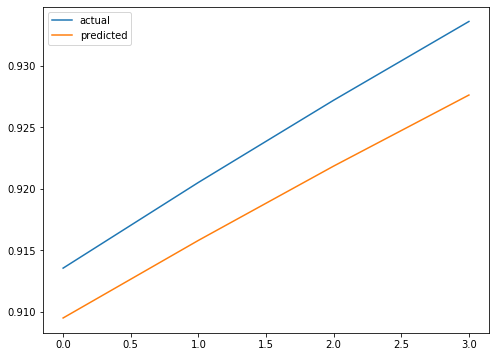

In [154]:
x_axis_values = [i for i in range(prediction_normalized.shape[0])]
plt.figure()
plt.plot(x_axis_values, y_test_uni, label='actual')
plt.plot(x_axis_values, prediction_denormalized, label='predicted')
plt.legend()
plt.show()

In [155]:
# For last predicted group:
list_absolute_error = []
list_signed_error = []
list_error_percentage = []
for actual,predicted in zip(y_test_uni,prediction_denormalized):
    actual = actual
    predicted = predicted[0]
    error = actual-predicted
    error_percentage = abs(error/actual)
    list_signed_error.append(error)
    list_absolute_error.append(abs(error))
    list_error_percentage.append(error_percentage)
    #print('actual =',actual,'; predicted =',predicted,'; error =',error,'; abs_error =',abs(error))
print('actual =',actual,'; predicted =',predicted,'; error =',error,'; abs_error =',abs(error),'; error_percentage =',abs(error_percentage))
print('len(list_absolute_error) =',len(list_absolute_error))
print('len(list_signed_error) =',len(list_signed_error))
print('len(list_error_percentage) =',len(list_error_percentage))

actual = 0.9335804264972019 ; predicted = 0.92760575 ; error = 0.005974678320627147 ; abs_error = 0.005974678320627147 ; error_percentage = 0.0063997467717314595
len(list_absolute_error) = 4
len(list_signed_error) = 4
len(list_error_percentage) = 4


In [156]:
print(y_test_uni.shape)
print(prediction_denormalized.shape)

(4,)
(4, 1)


In [157]:
index = 0
print('actual =',y_test_uni[index],'\npredicted =',prediction_denormalized[index],
      '\nerror =',list_signed_error[index],
      '\nabs_error =',list_absolute_error[index],
      '\nerror_percentage =',list_error_percentage[index])

actual = 0.9135454576426009 
predicted = [0.909497] 
error = 0.004048435013816687 
abs_error = 0.004048435013816687 
error_percentage = 0.004431563837297875


ERROR:

In [158]:
# ERROR: (previous error = 0.005019746610581216)
mean_mae_error = np.mean(np.asarray(list_absolute_error))
print('mean_mae_error =',mean_mae_error)

mean_mae_error = 0.005019746610581216


In [159]:
mean_error_percentage = np.mean(np.asarray(list_error_percentage))
print('mean_error_percentage =',mean_error_percentage)
#np.mean(np.asarray([1,2,3,4,5]))

mean_error_percentage = 0.005428437127291676


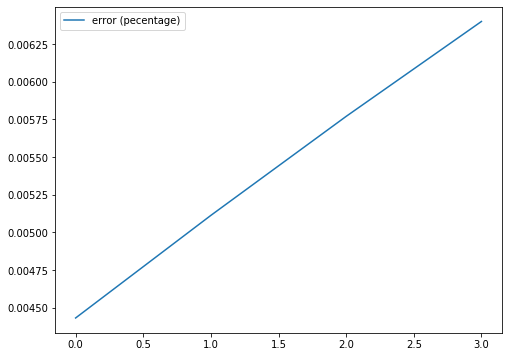

In [160]:
# Absolute error plotting:
x_axis_values = [i for i in range(prediction_normalized.shape[0])]
plt.figure()
plt.plot(x_axis_values, list_error_percentage, label='error (pecentage)')
plt.legend()
plt.show()

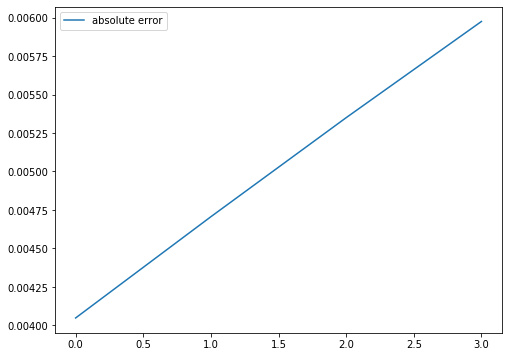

In [161]:
# Absolute error plotting:
x_axis_values = [i for i in range(prediction_normalized.shape[0])]
plt.figure()
plt.plot(x_axis_values, list_absolute_error, label='absolute error')
plt.legend()
plt.show()

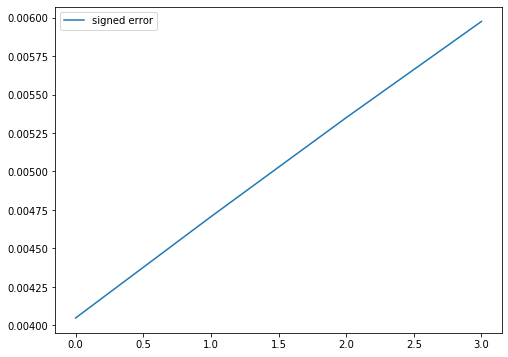

In [162]:
# Signed error plotting:
x_axis_values = [i for i in range(prediction_normalized.shape[0])]
plt.figure()
plt.plot(x_axis_values, list_signed_error, label='signed error')
plt.legend()
plt.show()

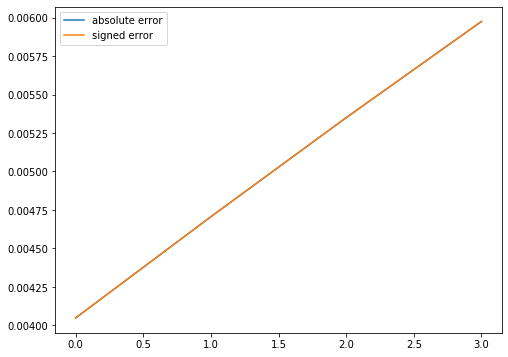

In [163]:
#'''
# Both errors plotting:
x_axis_values = [i for i in range(prediction_normalized.shape[0])]
plt.figure()
plt.plot(x_axis_values, list_absolute_error, label='absolute error')
plt.plot(x_axis_values, list_signed_error, label='signed error')
plt.legend()
plt.show()
#'''

History last = [0.90630779] ; True value = 0.9135454576426009 ; Predicted value = [0.909497]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

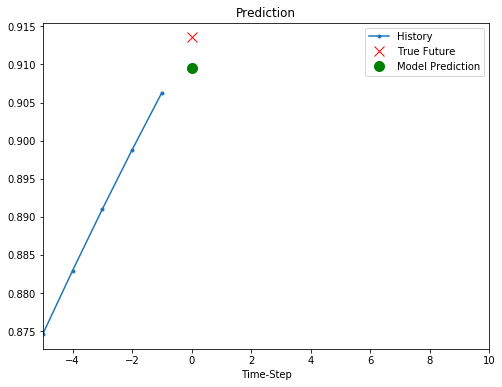

In [164]:
# REAL-TIME PREDICTION:
index = 0
print('History last =',x_test_uni[index][-1],'; True value =',y_test_uni[index],'; Predicted value =',prediction_denormalized[index])
show_plot([x_test_uni[index], y_test_uni[index], prediction_denormalized[index]], 0, 'Prediction')

History last = [0.92718385] ; True value = 0.9335804264972019 ; Predicted value = [0.92760575]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

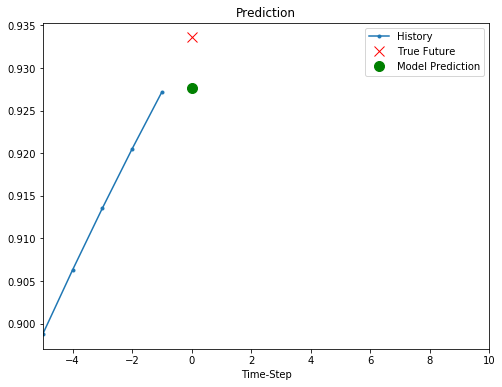

In [165]:
index = -1
print('History last =',x_test_uni[index][-1],'; True value =',y_test_uni[index],'; Predicted value =',prediction_denormalized[index])
show_plot([x_test_uni[index], y_test_uni[index], prediction_denormalized[index]], 0, 'Prediction')